# Kaggle Titanic Competition Data Analysis in Python

First of all, modules that will be used further along are imported. Pandas is used to facilitate csv reading and overall data wrangling, numpy is imported for certain functions used further along and seaborn is used for plots.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn import tree

# Setting of seaborn plotting style
sns.set(style = 'darkgrid')

Data is imported from csv files

In [22]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

### Exploratory Data Analysis and Data Preprocessing

Simple analysis of the data is carried out first to see how the data is structured, what issues we may face further along the line and find preliminary relations.

First analyses are on the variable names to check the consistency between variable names, differences between datasets, etc.

In [23]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


The summary information of the training data ser shows missing data (null values) for 'Age', 'Cabin' and 'Embarked' variables. This is due to the number of non-null values being less than the number of entries (891).

In [24]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


The same summary for the test dataset shows missing data for 'Age', 'Fare' and 'Cabin' variables.

There seems to be consistency with the column names of the different datasets. However, to be certain, a consistency check is carried to compared the above results.

In [25]:
train_data.columns.difference(test_data.columns)

Index(['Survived'], dtype='object')

The 'Survived' variable is not present in the test dataset. This must be considered when merging the two datasets.

Because the 'Survived' variable is not present in the test dataset, it will be set as NaN. This is necessary to create a dataset with all the data (training and test), as any further transformation must be carried out equally on any data used. For this reason it is easier to created a single dataset.

In [26]:
# setting missing variable in test dataset to NaN
test_data['Survived'] = np.nan

# complete dataset with all data
all_data = train_data.append(test_data, ignore_index=True)

An initial estimation of the incidence rates can foresee if the problem could present an imbalanced nature. Imbalanced datasets require further treatment as model training could lead to high accuracy with poor case (survival) detection.

In [27]:
all_data['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

Survival rates are around 38%, which means issues related to imbalanced datasets shouldn't be encountered.

Now that an initial analysis of the datatypes, structure of data and basic exploratory analyses have been carried out, a relational-based analysis will be carried out. The relation to be analysed is the output ('Survived' variable) against its multiple predictors (other covariates).

The first analysis will be on survival rates for men and women separately. This analysis is based on the "women and children" first code of conduct. Based on this code of conduct, it would be expected that men have poorer survival rates when compared to 
women.

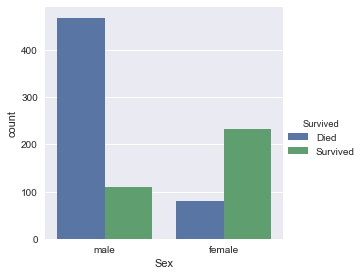

In [28]:
survived_map = {1.0: 'Survived', 0.0: 'Died'}

all_data['Survived'] = all_data['Survived'].map(survived_map)

sns.factorplot(x = 'Sex', hue = 'Survived', data = all_data, kind = 'count')

plt.show()

As can be seen from the above plot, survival rates for men are much lower than for women.

Next, based on the existence of excessive classism back in the early 20th century, a revision of survival rates by sex further stratified by passenger class will be carried out.

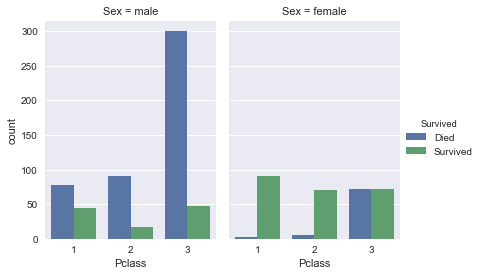

In [29]:
sns.factorplot(x = 'Pclass', hue = 'Survived', col = 'Sex',
                     data = all_data, kind = 'count',
                     aspect = 0.7)

plt.show()

Survival rates are severely jeopardized for 3rd class passengers. This can be observed with an increasing trend for death count from 1st to 3rd class for both men and women.

A similar analysis can be carried out by stratifying the passenger fare. Passenger fare was stratified into 10 deciles, grouping used due to the vast amount of unique passenger fares (282 in total with a maxima of little over 512 and minima of 0).

In [30]:
print(len(all_data['Fare'].unique()))
print(all_data['Fare'].max())
print(all_data['Fare'].min())


all_data['Fare_Range'] = pd.qcut(all_data['Fare'],
                                 q = np.linspace(0, 1, num = 11,
                                                    endpoint = True))

282
512.3292
0.0


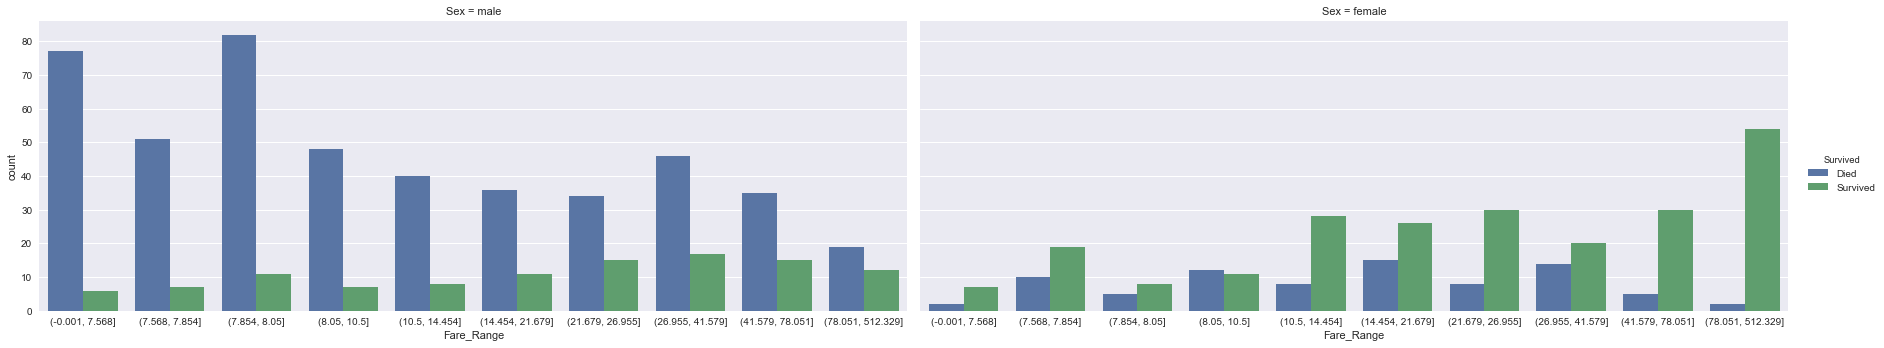

In [31]:
sns.factorplot(x = 'Fare_Range', hue = 'Survived', col = 'Sex',
               data = all_data, kind = 'count', size = 5,
               aspect = 2.5)

plt.show()

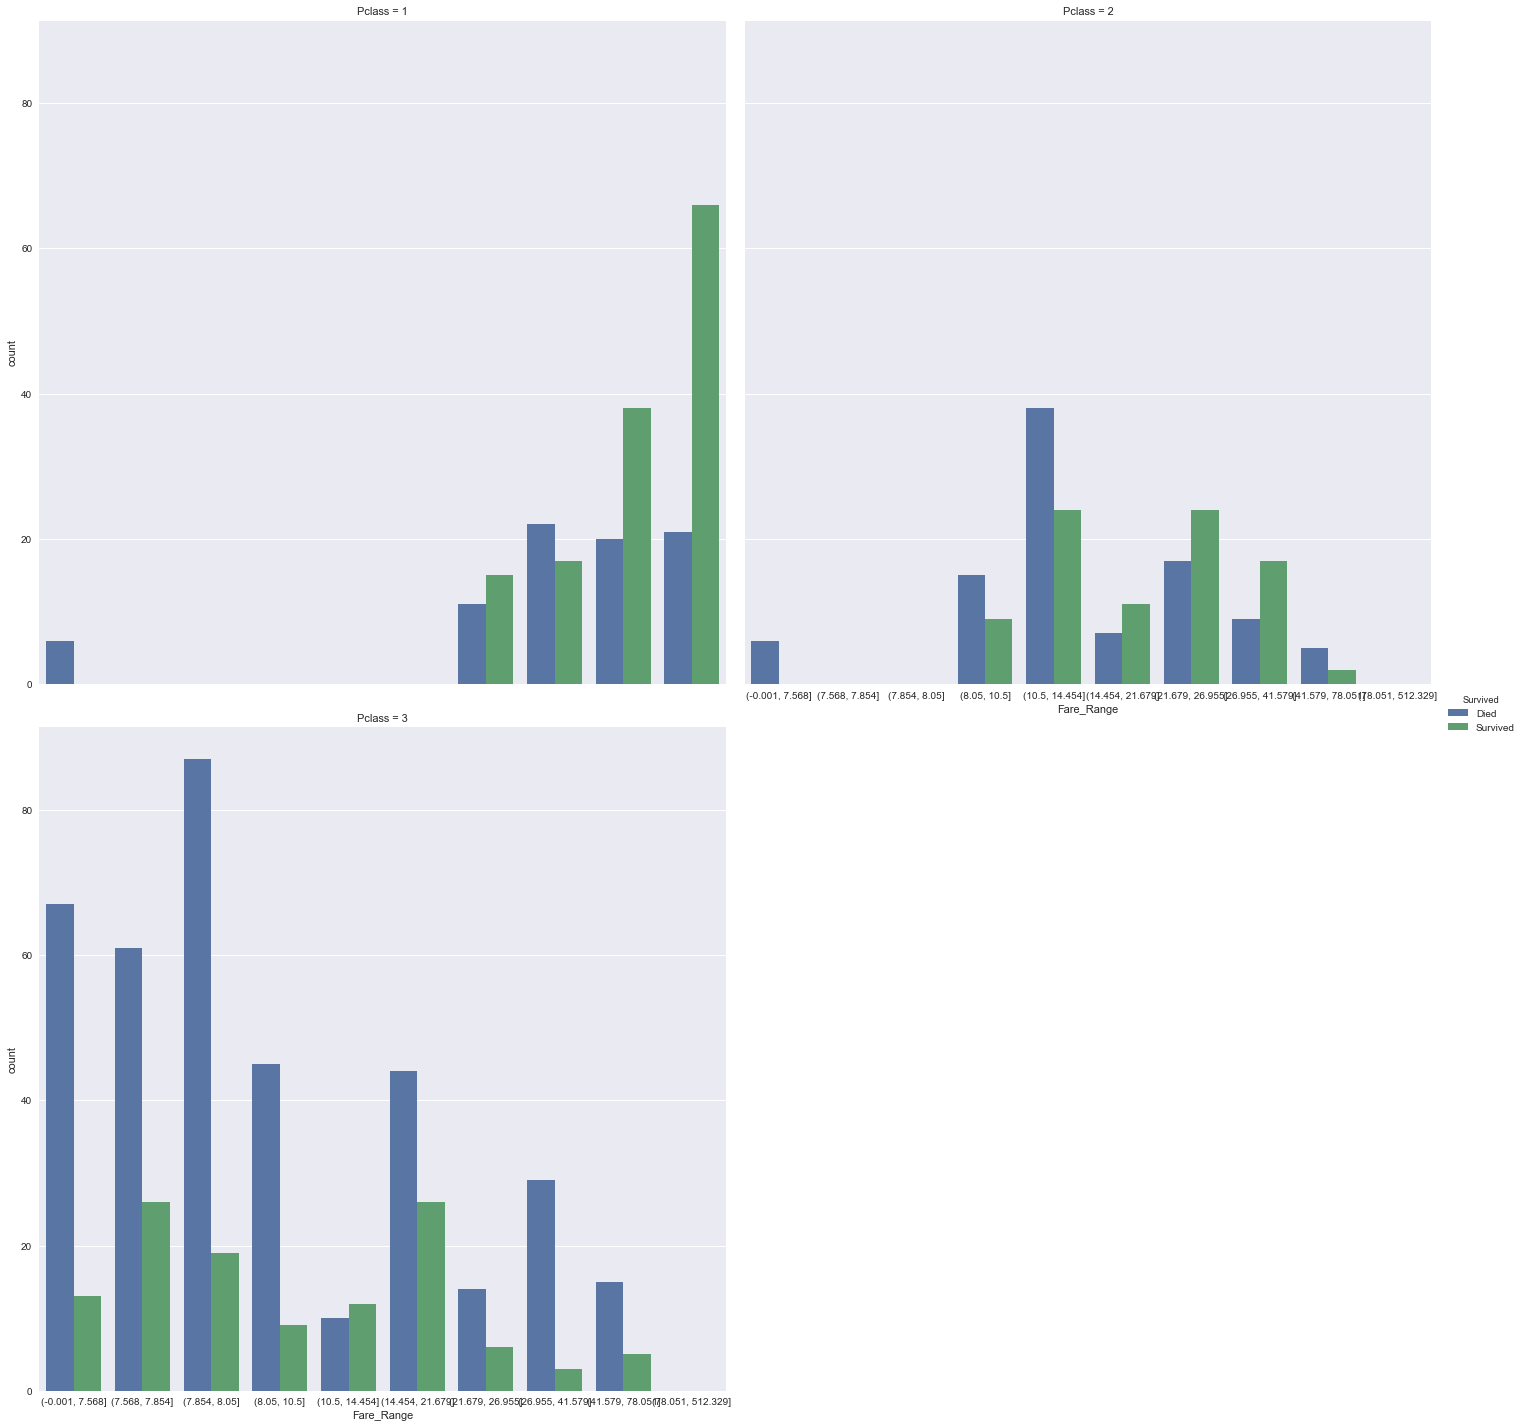

In [32]:
sns.factorplot(x = 'Fare_Range', hue = 'Survived', col = 'Pclass',
               data = all_data, kind = 'count', col_wrap = 2,
               size = 10, aspect = 1)

plt.show()

By using deciles of the passenger fare, outliers are detected in 1st and 2nd class, which suggests that using deciles of passenger fare instead of passenger class would improve classification.

In order to check the survival rates based on passenger age, a new variable was created 'Age_Range' that groups ages into children (0 to 12 years old), teenagers (12 to 18 years old), adults (18 to 65 years old) and elderly (65 and above).

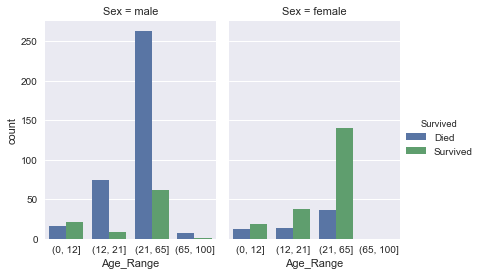

In [34]:
all_data['Age_Range'] = pd.cut(all_data['Age'], bins = [0, 12, 21, 65, 100])

sns.factorplot(x = 'Age_Range', hue = 'Survived', col = 'Sex',
                     data = all_data, kind = 'count',
                     aspect = 0.7)

plt.show()

Survival rates for men are better in the childrens age range (0 to 12) but overall, survival rates are still very poor in general for men. Also, the majority of men are adults (age between 21 and 65).

As for women's survival rates, they improve as age increases, with higher survival to death ratios for women between 18 and 65.

As age seems to play a relevant role in predicting survival of a passenger, missing data must be dealt with. The total amount of missing entries for 'Age_Range' is 263.

In [37]:
print(all_data['Age'].isnull().sum())

print(all_data['Age'].isnull().count())

print(np.round(all_data['Age'].isnull().sum() / all_data['Age'].isnull().count() * 100, 2))

263
1309
20.09


The amount of missing data is significant (over 20% of the total entries) and therefore cannot be discarded. The imputation of missing data can be with several methods such as mean imputation using complete cases, mean imputation using available cases, conditional mean and stochastic regression. We will be using stochastic regression, which involves regressing an output (in this case 'Age') based on other variables of the dataset. Before inferring the missing age values, a closer look will be taken to the passenger names.

In [14]:
all_data['Name'].head(20)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

Here we can observe the existence of information worth retrieving such as marital status and spouse's name. Married women were registered with their title (Mrs.) and there husband's name. This will be of relevance further along as it will allow to check family sizes (with the SibSp and and Parch variables, corresponding to no. siblings/spouses and no. parents/children on board, respectively).

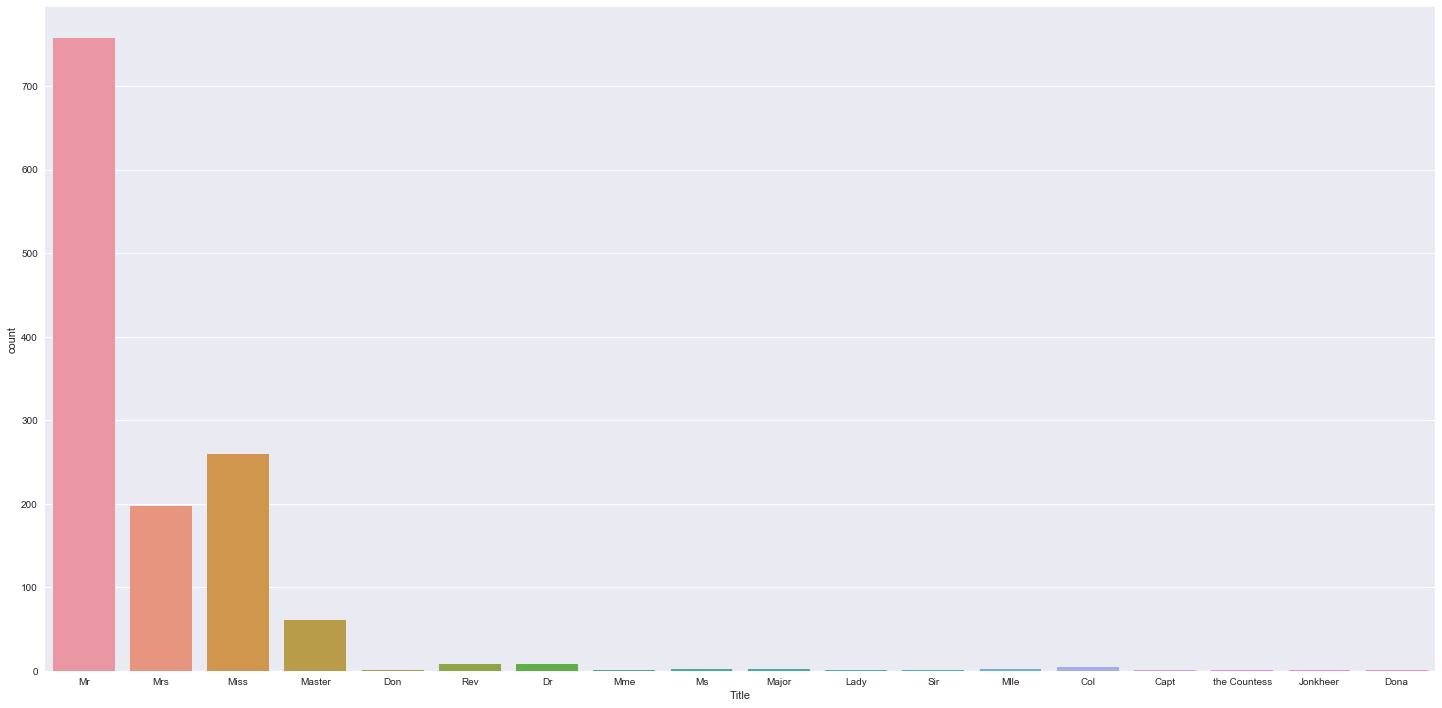

In [15]:
name_firstsplit = all_data['Name'].str.split(', ', expand = True)
name_secondsplit = name_firstsplit[1].str.split('.', expand = True)

all_data['Title'] = name_secondsplit[0]

sns.factorplot(x = 'Title', data = all_data,
              kind = 'count', size = 10,
              aspect = 2)
plt.show()

We analyse the survival rates for titles other than common UK titles (Mr, Mrs, Miss and Master).

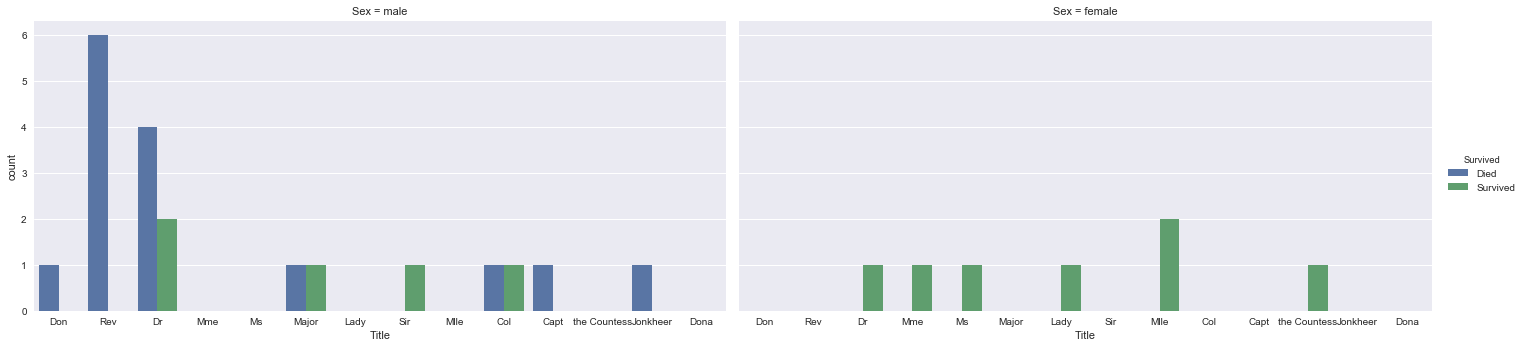

In [16]:
auxdf = all_data.loc[~all_data['Title'].isin(['Mr', 'Mrs', 'Miss', 'Master'])]

sns.factorplot(x = 'Title', hue = 'Survived', col = 'Sex', kind = 'count', data = auxdf, col_wrap = 2, size = 5, aspect = 2)

plt.show()

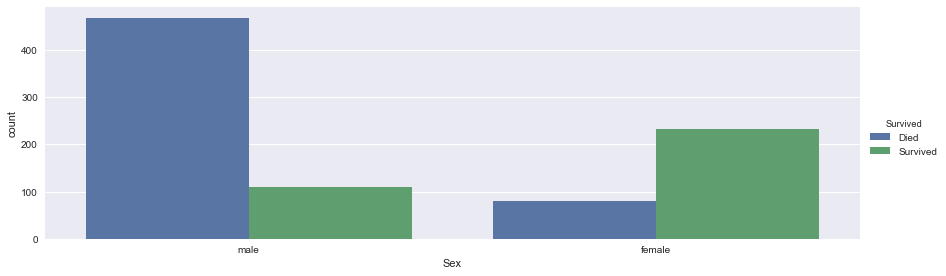

In [17]:
sns.factorplot(x = 'Sex', hue = 'Survived', kind = 'count', data = all_data, size = 4, aspect = 3)

plt.show()

As can be seen, survival rates can be stratified according to an uncommon title. It can be seen for men that survival rates change significantly with uncommon titles in comparison to the overall survival rates for men (seen in the immediately above plot).

All titles other than 'Mr', 'Mrs', 'Miss', 'Master', 'Dr' and 'Rev' were grouped into new categories to account for exceptions in survival rates. These are associated to nobility and military positions. Doctors and reverends were not reclasified as they were considered titles associated to extremely altruistic behaviour and thus could determine the survival of a passenger.

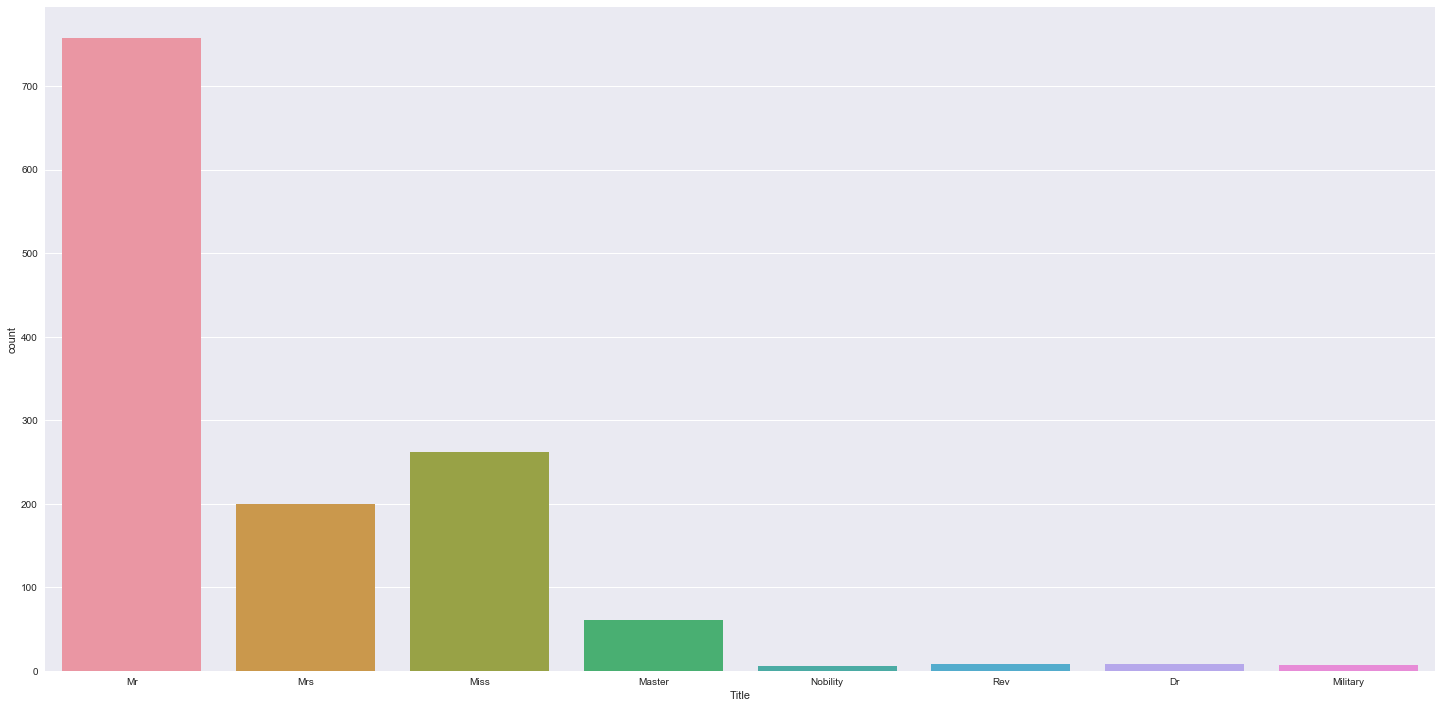

In [18]:
title_map = {'Don': 'Nobility', 'Dona': 'Nobility', 'Jonkheer': 'Nobility', 'the Countess': 'Nobility', 'Sir': 'Nobility',
             'Lady': 'Nobility',
             'Mme': 'Mrs', 'Ms': 'Mrs',
             'Mlle': 'Miss',
             'Major': 'Military', 'Col': 'Military', 'Capt': 'Military',
             'Dr': 'Dr', 'Rev': 'Rev',
             'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master'}
all_data['Title'] = all_data['Title'].map(title_map)

sns.factorplot(x = 'Title', data = all_data,
              kind = 'count', size = 10,
              aspect = 2)
plt.show()

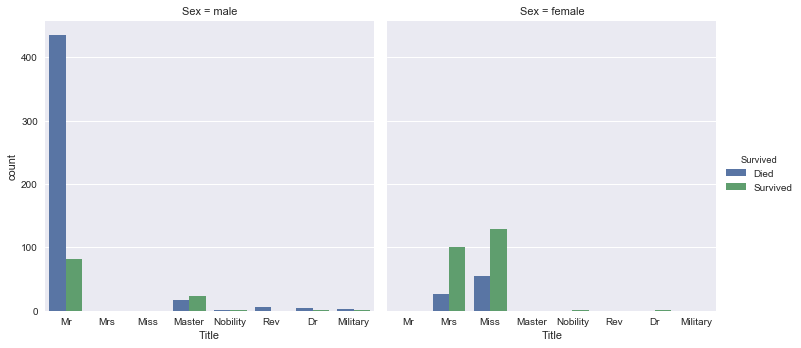

In [19]:
sns.factorplot(x = 'Title', hue = 'Survived', col = 'Sex', kind = 'count', data = all_data, col_wrap = 2, size = 5, aspect = 1)

plt.show()

Before imputing the missing Age values we shall check the existing values.

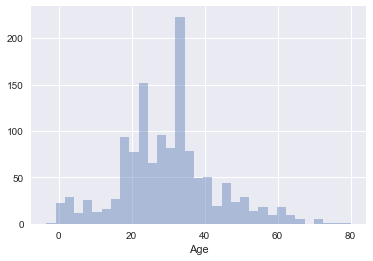

In [29]:
sns.distplot(all_data['Age'], kde = False)

plt.show()

As can be noted from the histogram, there are negative values for Age. This is an inconsistency with the nature of the data and must be corrected.

The details of this entry is as follows.

In [31]:
all_data[all_data['Age'] == all_data['Age'].min()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Fare_Range,Age_Range,Title
159,-3.395901,NaN,S,69.55,"Sage, Master. Thomas Henry",2,160,3,male,8,Died,CA. 2343,"(41.579, 78.02]",NaN,Master


The title is Master, suggesting an unmarried male. Because we have no further information and given the specificity of the Age value (which only stands out because of its negative sign), we will simply impute said value with its absolute value.

In [34]:
all_data.loc[all_data['Age'] == all_data['Age'].min(), 'Age'] = np.absolute(all_data['Age'].min())

print(all_data['Age'].min())

0.17


Now the imputation of missing Age values can be carried out.

In [35]:
model_Age = ols('Age ~ Title + SibSp + Parch', data = all_data).fit()

In [49]:
pred_all_data_Age = model_Age.predict(all_data) + np.random.lognormal(mean = 0,
                                                                      sigma = np.sqrt(model_Age.scale),
                                                                      size = len(all_data)) 

In [50]:
print(all_data['Age'].head())

print(pred_all_data_Age.head())

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64
0    5.523801e+01
1    1.582515e+08
2    2.278493e+01
3    3.667996e+01
4    3.310803e+01
dtype: float64


In [24]:
all_data.Age.fillna(model_Age.predict(all_data[['Title', 'SibSp', 'Parch']]), inplace = True)

all_data['Age_Range'] = pd.cut(all_data['Age'], bins = [0, 12, 18, 65, 100])

print(all_data[all_data['Age'] == all_data['Age'].min()]['Age'])

159   -3.395901
Name: Age, dtype: float64


The imputation of missing Fare values is now carried out with the completed Age dataset.

In [25]:
model_Fare = ols('Fare ~ Title + SibSp + Parch + Age', data = all_data).fit()

In [26]:
all_data.Fare.fillna(model_Fare.predict(all_data[['Title', 'SibSp', 'Parch', 'Age']]), inplace = True)

all_data['Fare_Range'] = pd.qcut(all_data['Fare'],
                                 q = np.linspace(0, 1, num = 11,
                                                    endpoint = True))

### Model fitting

The underlying problem is a binary classification problem.

In [27]:
TrainFeatures = all_data.loc[~all_data['Survived'].isnull()][['Age_Range', 'Title', 'Fare_Range', 'Sex']]
TrainTarget = all_data.loc[~all_data['Survived'].isnull()][['Survived']]

#TrainFeatures.apply(lambda x: x.astype('category'))
#TrainFeatures.apply(lambda x: x.cat.codes)



TrainTarget['Survived'] = TrainTarget['Survived'].astype('category')
TrainTarget['Survived'] = TrainTarget['Survived'].cat.codes

print(TrainFeatures.info())

DecisionTree = tree.DecisionTreeClassifier()

DecisionTree = DecisionTree.fit(TrainFeatures, TrainTarget)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 4 columns):
Age_Range     890 non-null category
Title         891 non-null object
Fare_Range    891 non-null category
Sex           891 non-null object
dtypes: category(2), object(2)
memory usage: 22.8+ KB
None


ValueError: could not convert string to float: 'male'